In [1]:
import pyvinecopulib as pv
import numpy as np
import pickle
import scipy.stats as scs
from Ratio import *
from Ratio_L_and_W import *
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import torch
import joblib


### Sampling the data for 2D experiments

In [2]:
# load the samples
'''
def sample(cop_name, nsamples, params):
    if cop_name == "gaussian":
        corrMatrix = params["corrMatrix"]
        copula = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=corrMatrix)
    elif cop_name == "student":
        corrMatrix = params["corrMatrix"]
        nu = params["nu"]
        copula = pv.Bicop(family=pv.BicopFamily.student, parameters=[corrMatrix, nu])
    elif cop_name == "clayton":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.clayton, parameters=theta)
    elif cop_name == "gumbel":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=theta)
    elif cop_name == "mixture":
        combination = params["combination"]
        copulas = [pv.Bicop(family=pv.BicopFamily[comp["type"]], parameters=comp["theta"]) for comp in combination]
        weights = [comp["weight"] for comp in combination]
        copula = pv.MixtureBicop(copulas, weights)
    else:
        raise ValueError(f"Unknown copula type: {cop_name}")
    
    return copula.simulate(nsamples)

def log_likelihood(cop_name, u1, u2, params):
    if cop_name == "gaussian":
        corrMatrix = params["corrMatrix"]
        copula = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=corrMatrix)
    elif cop_name == "student":
        corrMatrix = params["corrMatrix"]
        nu = params["nu"]
        copula = pv.Bicop(family=pv.BicopFamily.student, parameters=[corrMatrix, nu])
    elif cop_name == "clayton":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.clayton, parameters=theta)
    elif cop_name == "gumbel":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=theta)
    else:
        raise ValueError(f"Unknown copula type: {cop_name}")
    
    data = np.column_stack((u1, u2))
    return copula.loglik(data)

# Example usage:
#params_gaussian = {"corrMatrix": [0.1]}
#samples = sample("gaussian", 500, params_gaussian)
#u1, u2 = samples[:, 0], samples[:, 1]
#log_likelihood_value = log_likelihood("gaussian", u1, u2, params_gaussian)
#print(log_likelihood_value)


N_TRAIN = 5000
N_TEST = 5000
N_ROUNDS = 25
np.random.seed(990109)

sims_runs_all = []
log_likelihoods_runs_all = []

for round in tqdm(range(N_ROUNDS)):
    # Generate data

    # Student-t
    corrMatrix = np.random.uniform(0.5,0.95)
    nu = np.random.uniform(2,10)

    params_student = {"corrMatrix": corrMatrix, "nu": nu}
    samples_student = sample("student", N_TRAIN + N_TEST, params_student)
    u1_student, u2_student = samples_student[:, 0], samples_student[:, 1]
    log_likelihood_student = log_likelihood("student", u1_student[N_TRAIN:], u2_student[N_TRAIN:], params_student)

    # Clayton
    theta = 2
    params_clayton = {"theta": [theta]}
    samples_clayton = sample("clayton", N_TRAIN + N_TEST, params_clayton)
    u1_clayton, u2_clayton = samples_clayton[:, 0], samples_clayton[:, 1]
    log_likelihood_clayton = log_likelihood("clayton", u1_clayton[N_TRAIN:], u2_clayton[N_TRAIN:], params_clayton)

    # Gumbel
    theta = 2
    params_gumbel = {"theta": [theta]}
    samples_gumbel = sample("gumbel", N_TRAIN + N_TEST, params_gumbel)
    u1_gumbel, u2_gumbel = samples_gumbel[:, 0], samples_gumbel[:, 1]
    log_likelihood_gumbel = log_likelihood("gumbel", u1_gumbel[N_TRAIN:], u2_gumbel[N_TRAIN:], params_gumbel)

    # Gaussian copula mixture
    mu_1 = np.random.uniform(-5,5,2)
    sigma_1 = (np.eye(2)+np.eye(2)[[1,0],:]*np.random.uniform(-0.95,0.95,1))*np.random.uniform(0.8,1.2)
    
    mu_2 = np.random.uniform(-5,5,2)
    sigma_2 = (np.eye(2)+np.eye(2)[[1,0],:]*np.random.uniform(-0.95,0.95,1))*np.random.uniform(0.8,1.2)
    size_ = int((N_TRAIN+N_TEST)/2)
    x1 = np.random.multivariate_normal(mean=mu_1, cov=sigma_1, size=size_)
    x2 = np.random.multivariate_normal(mean=mu_2, cov=sigma_2, size=size_)

    X = np.vstack([x1,x2])
    np.random.shuffle(X)
    
    cdf_1 = fit_ecdf(X[:,0])
    cdf_2 = fit_ecdf(X[:,1])
    u_1_mix = cdf_1(X[:,0])
    u_2_mix = cdf_2(X[:,1])

    log_likelihood_mix_top =    np.log(0.5*scs.multivariate_normal.pdf(X[N_TRAIN:], mean=mu_1, cov=sigma_1) + 0.5*scs.multivariate_normal.pdf(X[N_TRAIN:], mean=mu_2, cov=sigma_2)).sum()
    log_likelihood_mix_bottom = np.log(0.5*scs.norm(loc=mu_1[0], scale=sigma_1[0,0]).pdf(X[N_TRAIN:,0]).sum() + 0.5*scs.norm(loc=mu_2[0], scale=sigma_2[0,0]).pdf(X[N_TRAIN:,0])) 
    log_likelihood_mix_bottom +=np.log(0.5*scs.norm(loc=mu_1[1], scale=sigma_1[1,1]).pdf(X[N_TRAIN:,1]).sum() + 0.5*scs.norm(loc=mu_2[1], scale=sigma_2[1,1]).pdf(X[N_TRAIN:,1]))
    log_likelihood_mix = log_likelihood_mix_top - log_likelihood_mix_bottom.sum()

    # append to list
    sims_runs_all.append([[u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]])
    log_likelihoods_runs_all.append([log_likelihood_student, log_likelihood_clayton, log_likelihood_gumbel, log_likelihood_mix])

# save sims_runs_all as a csv
#sims_runs_all = np.array(sims_runs_all)
#with open('simulated_data_25_runs_4copulas_2Dexperiment.pkl', 'wb') as f:
#    pickle.dump(sims_runs_all, f)
'''
# load sims_runs_all from a pkl file
with open('simulated_data_25_runs_4copulas_2Dexperiment.pkl', 'rb') as f:
    sims_runs_all = pickle.load(f)


In [3]:
sims_runs_all = np.array(sims_runs_all)
sims_runs_all.shape

(25, 4, 2, 10000)

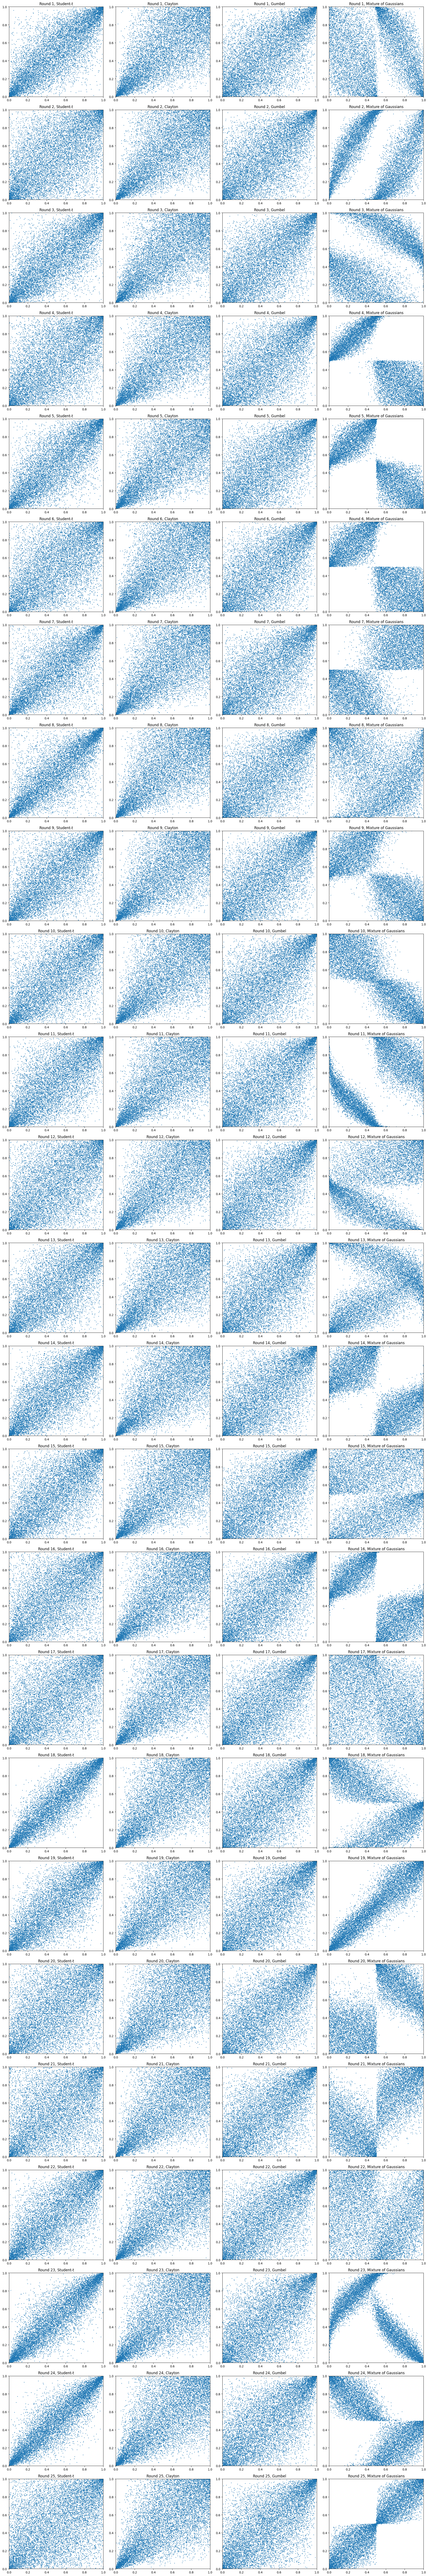

In [4]:
# Assuming sims_runs_all is already populated with the samples

fig, axes = plt.subplots(25, 4, figsize=(20, 120))
axes = axes.flatten()

sample_types = ["Student-t", "Clayton", "Gumbel", "Mixture of Gaussians"]

for i in range(25):
    for j in range(4):
        ax = axes[i * 4 + j]
        u1, u2 = sims_runs_all[i][j]
        ax.scatter(u1, u2, s=1)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f'Round {i+1}, {sample_types[j]}')

plt.tight_layout()
plt.show()

### Fitting parametric estimators - samples and density estimation

In [5]:
'''
np.random.seed(990109)
log_likelihoods_runs_all_models = [[],[],[],[]]

for r,run in tqdm(enumerate(sims_runs_all)):
    # run = [u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]
    for u,u1_u2 in enumerate(run):
        # u1_u2 = [u1_student, u2_student]
        u_obs = np.column_stack(u1_u2)
        u_train = u_obs[:N_TRAIN]
        u_test = u_obs[N_TRAIN:]
        # GAUSS
        cop_gauss = pv.Bicop(family=pv.BicopFamily.gaussian)
        cop_gauss.fit(data=u_train)
        log_likelihood_gauss = cop_gauss.loglik(u=u_test)
        # TLL cst
        controls = pv.FitControlsBicop(family_set = [pv.BicopFamily.tll],nonparametric_method='constant')
        cop_tll_cst = pv.Bicop(data=u_train, controls=controls)
        log_likelihood_tll = cop_tll_cst.loglik(u=u_test)
        # TLL linear
        controls = pv.FitControlsBicop(family_set = [pv.BicopFamily.tll],nonparametric_method='linear')
        cop_tll_lin = pv.Bicop(data=u_train, controls=controls)
        log_likelihood_tll_lin = cop_tll_lin.loglik(u=u_test)
        # TLL quadratic
        controls = pv.FitControlsBicop(family_set = [pv.BicopFamily.tll],nonparametric_method='quadratic')
        cop_tll_quad = pv.Bicop(data=u_train, controls=controls)
        log_likelihood_tll_quad = cop_tll_quad.loglik(u=u_test)

        log_likelihoods_runs_all_models[u].append([log_likelihood_gauss, log_likelihood_tll, log_likelihood_tll_lin, log_likelihood_tll_quad])


# save them as a pkl
with open('ll_baselines_25_runs_4copulas_2Dexperiment.pkl', 'wb') as f:
    pickle.dump(np.array(log_likelihoods_runs_all_models), f)

'''
# load them from a pkl file
with open('ll_baselines_25_runs_4copulas_2Dexperiment.pkl', 'rb') as f:
    log_likelihoods_runs_all_models = pickle.load(f)

In [6]:


# Load the saved L_ratios_all
with open('model_parameters_L_ratio_25_runs_4copulas_2Dexperiment/L_ratios_all_25_runs_4copulas_2Dexperiment.pkl', 'rb') as f:
    L_ratios_all = pickle.load(f)

# Initialize a list to store log-likelihood values
L_ratios_ll = []

np.random.seed(990109)
torch.manual_seed(990109)

N_TRAIN = 5000
N_TEST = 5000

for r, run in enumerate(sims_runs_all):
    for u, u1_u2 in enumerate(run):
        # Load the saved model and polynomial feature transformer
        model_path = f'model_parameters_L_ratio_25_runs_4copulas_2Dexperiment/L_ratio_run_{r}_cop_u_{u}_model.pkl'
        poly_path = f'model_parameters_L_ratio_25_runs_4copulas_2Dexperiment/L_ratio_run_{r}_cop_u_{u}_poly.pkl'
        
        model = joblib.load(model_path)
        poly = joblib.load(poly_path)
        
        # Prepare the test data
        z1_test, z2_test = scs.norm.ppf(u1_u2[0][N_TRAIN:]), scs.norm.ppf(u1_u2[1][N_TRAIN:])
        p_data_test = np.column_stack((z1_test, z2_test))
        p_data_test = np.nan_to_num(p_data_test, nan=0, posinf=6., neginf=-6.)
        
        # Compute log-likelihood using the loaded model and polynomial feature transformer
        ratio = [(model, poly)]
        ll_value = L_W_ratio_compute(ratio, p_data_test, log_pdf=True).sum()
        L_ratios_ll.append(ll_value)
        print('run', r, 'cop_u', u, 'log-likelihood:', ll_value)

# Print the final log-likelihood values
print('Log-likelihood values:', L_ratios_ll)

c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to

run 0 cop_u 0 log-likelihood: 2678.45496672661
run 0 cop_u 1 log-likelihood: 2048.717542742052
run 0 cop_u 2 log-likelihood: 1778.9070977476192
run 0 cop_u 3 log-likelihood: 750.5362791730274
run 1 cop_u 0 log-likelihood: 1160.1902576021089
run 1 cop_u 1 log-likelihood: 2025.3218024514308
run 1 cop_u 2 log-likelihood: 1747.2977523043937
run 1 cop_u 3 log-likelihood: 2700.299592714992
run 2 cop_u 0 log-likelihood: 2412.938429459142
run 2 cop_u 1 log-likelihood: 2048.202558036311
run 2 cop_u 2 log-likelihood: 1808.837047301096
run 2 cop_u 3 log-likelihood: 1710.1270860320697
run 3 cop_u 0 log-likelihood: 1281.3901244974343
run 3 cop_u 1 log-likelihood: 2039.8467590167616
run 3 cop_u 2 log-likelihood: 1785.6362061742084
run 3 cop_u 3 log-likelihood: 3932.8179023102502
run 4 cop_u 0 log-likelihood: 2486.36685017838
run 4 cop_u 1 log-likelihood: 2003.0585794344895


c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to

run 4 cop_u 2 log-likelihood: 1767.1570342599775
run 4 cop_u 3 log-likelihood: 3769.1734152063573
run 5 cop_u 0 log-likelihood: 1386.6327509639725
run 5 cop_u 1 log-likelihood: 2136.0344614144697
run 5 cop_u 2 log-likelihood: 1797.1416826124957
run 5 cop_u 3 log-likelihood: 2890.4280974736403
run 6 cop_u 0 log-likelihood: 2059.0287884726013
run 6 cop_u 1 log-likelihood: 2045.2080461830387
run 6 cop_u 2 log-likelihood: 1815.0481814346856
run 6 cop_u 3 log-likelihood: 1660.3155797819097
run 7 cop_u 0 log-likelihood: 2926.7874647743265
run 7 cop_u 1 log-likelihood: 2086.138256143119
run 7 cop_u 2 log-likelihood: 1856.7332569457928
run 7 cop_u 3 log-likelihood: 876.9575821282344
run 8 cop_u 0 log-likelihood: 1943.048515316962
run 8 cop_u 1 log-likelihood: 2127.3173100609783
run 8 cop_u 2 log-likelihood: 1870.3794445017309
run 8 cop_u 3 log-likelihood: 2476.7736952258065
run 9 cop_u 0 log-likelihood: 1625.8207219002102
run 9 cop_u 1 log-likelihood: 2211.994791422752


c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to

run 9 cop_u 2 log-likelihood: 1672.7296587487388
run 9 cop_u 3 log-likelihood: 2964.050842353103
run 10 cop_u 0 log-likelihood: 2116.0234560399063
run 10 cop_u 1 log-likelihood: 2016.709350428774
run 10 cop_u 2 log-likelihood: 1706.159396804476
run 10 cop_u 3 log-likelihood: 3588.06759952182
run 11 cop_u 0 log-likelihood: 1078.9263165939485
run 11 cop_u 1 log-likelihood: 2021.1568723058606
run 11 cop_u 2 log-likelihood: 1879.338772936464
run 11 cop_u 3 log-likelihood: 1337.7397752535217
run 12 cop_u 0 log-likelihood: 1873.0846879554033
run 12 cop_u 1 log-likelihood: 1944.8389658938331
run 12 cop_u 2 log-likelihood: 1844.6613585830528
run 12 cop_u 3 log-likelihood: 1803.2431375485103
run 13 cop_u 0 log-likelihood: 2380.3331739179953
run 13 cop_u 1 log-likelihood: 1975.9780076746622
run 13 cop_u 2 log-likelihood: 1830.0878196021758
run 13 cop_u 3 log-likelihood: 2564.5389084840926
run 14 cop_u 0 log-likelihood: 1805.8855469624414


c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to

run 14 cop_u 1 log-likelihood: 2062.937044080901
run 14 cop_u 2 log-likelihood: 1809.1601852247027
run 14 cop_u 3 log-likelihood: 282.49623533421425
run 15 cop_u 0 log-likelihood: 1371.1182905043217
run 15 cop_u 1 log-likelihood: 2032.9400547712235
run 15 cop_u 2 log-likelihood: 1767.697657320518
run 15 cop_u 3 log-likelihood: 3401.591323933671
run 16 cop_u 0 log-likelihood: 1156.6574187835981
run 16 cop_u 1 log-likelihood: 2074.637942266246
run 16 cop_u 2 log-likelihood: 1833.322797105054
run 16 cop_u 3 log-likelihood: 396.54717150451484
run 17 cop_u 0 log-likelihood: 4735.7629279999965
run 17 cop_u 1 log-likelihood: 2014.722586790702
run 17 cop_u 2 log-likelihood: 1884.2412970758924
run 17 cop_u 3 log-likelihood: 2221.7097667422913
run 18 cop_u 0 log-likelihood: 2702.83336788994
run 18 cop_u 1 log-likelihood: 2111.449184294551
run 18 cop_u 2 log-likelihood: 1947.3935772275386
run 18 cop_u 3 log-likelihood: 4832.860811624763
run 19 cop_u 0 log-likelihood: 1080.4406840083188
run 19 cop

c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to

run 19 cop_u 3 log-likelihood: 1974.0847016391956
run 20 cop_u 0 log-likelihood: 1015.96894863974
run 20 cop_u 1 log-likelihood: 2031.4025504501355
run 20 cop_u 2 log-likelihood: 1817.6329806636807
run 20 cop_u 3 log-likelihood: 1865.7762721245424
run 21 cop_u 0 log-likelihood: 2506.629859273283
run 21 cop_u 1 log-likelihood: 2147.7090472560394
run 21 cop_u 2 log-likelihood: 1705.874236380611
run 21 cop_u 3 log-likelihood: 216.3977021423771
run 22 cop_u 0 log-likelihood: 4211.503270660669
run 22 cop_u 1 log-likelihood: 2197.8962103205677
run 22 cop_u 2 log-likelihood: 1796.7571572752202
run 22 cop_u 3 log-likelihood: 5318.251598895631
run 23 cop_u 0 log-likelihood: 4349.646976787633
run 23 cop_u 1 log-likelihood: 2251.717590520726
run 23 cop_u 2 log-likelihood: 1774.0807633725549
run 23 cop_u 3 log-likelihood: 3311.3277831092855
run 24 cop_u 0 log-likelihood: 810.9719968923602
run 24 cop_u 1 log-likelihood: 2122.2187967366112
run 24 cop_u 2 log-likelihood: 1813.9374522910302
run 24 cop

c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to

In [7]:


N_TRAIN = 5000
N_TEST = 5000

# Load the saved log-likelihood values
with open('ratio_ll_25_runs_4copulas_2Dexperiment.pkl', 'rb') as f:
    ratio_ll = pickle.load(f)

# Initialize a list to store log-likelihood values for the loaded models
loaded_ratios_ll = []

# Load and evaluate the models
for r, run in enumerate(sims_runs_all):
    for u, u1_u2 in enumerate(run):
        # Load the saved model
        model_path = f'model_parameters_NNet_ratio_25_runs_4copulas_2Dexperiment/NNet_ratio_run_{r}_cop_u_{u}_ok.pt'
        ratio = Ratio(h_dim=100, in_dim=2, h_layers=2, normalising_cst=True)
        ratio.load_state_dict(torch.load(model_path))
        ratio.eval()
        
        # Prepare the test data
        z1_test, z2_test = scs.norm.ppf(u1_u2[0][N_TRAIN:N_TRAIN+N_TEST]), scs.norm.ppf(u1_u2[1][N_TRAIN:N_TRAIN+N_TEST])
        p_data_test = np.column_stack((z1_test, z2_test))
        p_data_test = np.nan_to_num(p_data_test, nan=0, posinf=6., neginf=-6.)
        
        # Evaluate the model on the test data
        with torch.no_grad():
            r_test = ratio(torch.tensor(p_data_test).float())
            ll_value = r_test.log().sum().detach().numpy()
            loaded_ratios_ll.append(ll_value)
            print('run', r, 'cop_u', u, 'log-likelihood:', ll_value)

# Print the final log-likelihood values
print('Log-likelihood values for loaded models:', loaded_ratios_ll)

C:\Users\u1819911\AppData\Local\Temp\ipykernel_6676\2615740532.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ratio.load_state_dict(torch.load(model_path))


run 0 cop_u 0 log-likelihood: 2809.3337
run 0 cop_u 1 log-likelihood: 1676.1969
run 0 cop_u 2 log-likelihood: 1533.6647
run 0 cop_u 3 log-likelihood: 1213.5352
run 1 cop_u 0 log-likelihood: 1116.7294
run 1 cop_u 1 log-likelihood: 2111.3384
run 1 cop_u 2 log-likelihood: 1573.462
run 1 cop_u 3 log-likelihood: 3135.5618
run 2 cop_u 0 log-likelihood: 2407.5168
run 2 cop_u 1 log-likelihood: 1980.0205
run 2 cop_u 2 log-likelihood: 1764.0194
run 2 cop_u 3 log-likelihood: 2044.061
run 3 cop_u 0 log-likelihood: 1330.8962
run 3 cop_u 1 log-likelihood: 1863.737
run 3 cop_u 2 log-likelihood: 1882.1035
run 3 cop_u 3 log-likelihood: 4772.598
run 4 cop_u 0 log-likelihood: 2615.8552
run 4 cop_u 1 log-likelihood: 2158.5205
run 4 cop_u 2 log-likelihood: 1595.732
run 4 cop_u 3 log-likelihood: 4664.314
run 5 cop_u 0 log-likelihood: 1292.733
run 5 cop_u 1 log-likelihood: 1764.8823
run 5 cop_u 2 log-likelihood: 1864.6326
run 5 cop_u 3 log-likelihood: 3603.7437
run 6 cop_u 0 log-likelihood: 2326.7666
run 6 c

Size of L_ratios_all: 100


C:\Users\u1819911\AppData\Local\Temp\ipykernel_6676\4087740438.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Log-Likelihood', data=df, ax=axes[idx], palette=palette, linewidth=3,flierprops=dict(marker='o', markersize=10, linestyle='none', markeredgecolor='black'))
C:\Users\u1819911\AppData\Local\Temp\ipykernel_6676\4087740438.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Log-Likelihood', data=df, ax=axes[idx], palette=palette, linewidth=3,flierprops=dict(marker='o', markersize=10, linestyle='none', markeredgecolor='black'))
C:\Users\u1819911\AppData\Local\Temp\ipykernel_6676\4087740438.py:54: FutureWarning: 

Passing `palette` without assigning `

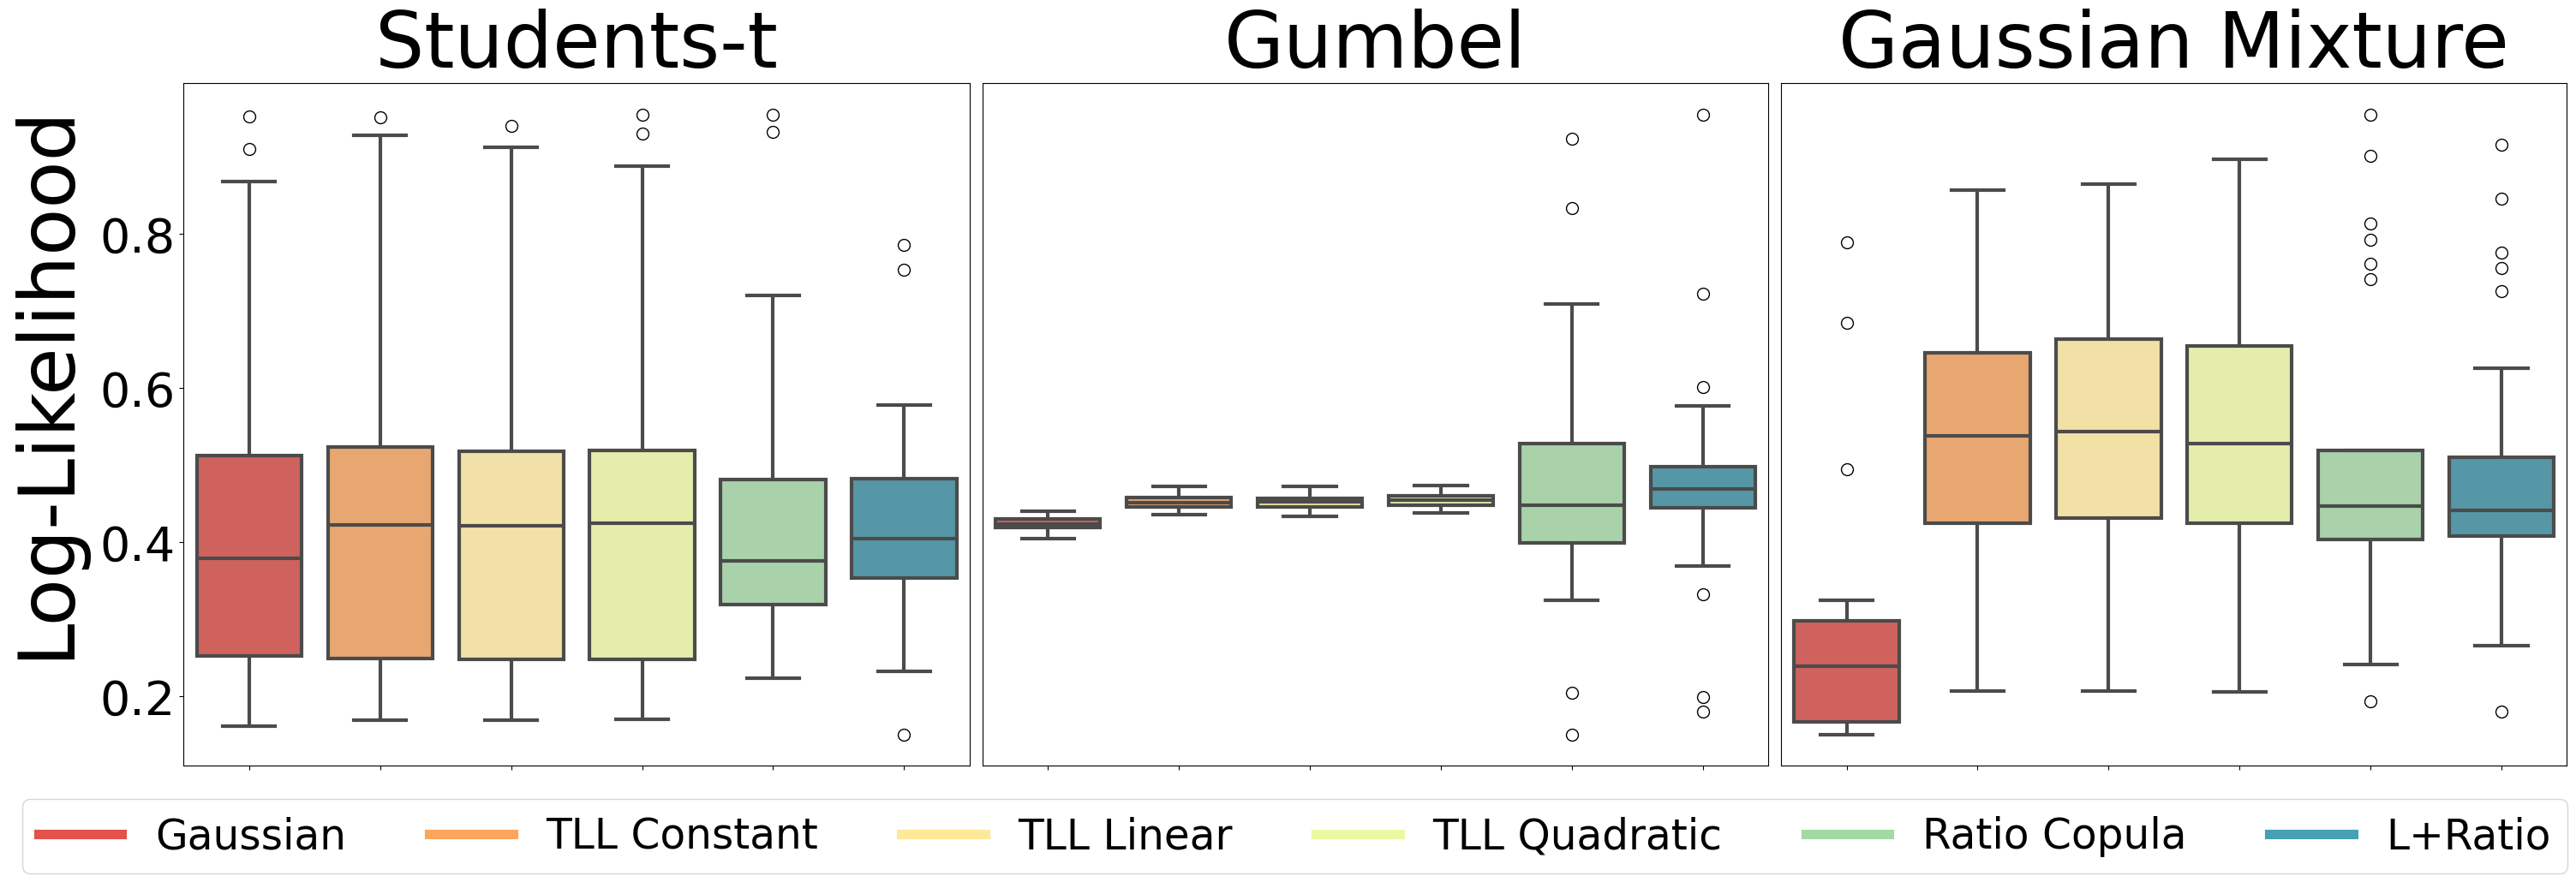

In [8]:


# Set the font size parameters
fnt_size = 65
tick_size = 40  # Variable to control the size of the numbers on the right axis

# Assuming log_likelihoods_runs_all_models, ratio_ll, and L_ratios_all are already defined
log_likelihoods_runs_all_models = np.array(log_likelihoods_runs_all_models)
ratio_cop_2d_ll = np.array(loaded_ratios_ll).reshape(4, 25)

# Check the size of L_ratios_all
L_ratios_all_array = np.array(L_ratios_ll)
print(f"Size of L_ratios_all: {L_ratios_all_array.size}")

# Ensure the size is correct before reshaping
if L_ratios_all_array.size == 100:
    L_ratios_all_array = L_ratios_all_array.reshape(4, 25)
else:
    raise ValueError(f"Expected size of L_ratios_all to be 100, but got {L_ratios_all_array.size}")

# Create subplots (excluding Clayton copula)
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

methods = ['Gaussian', 'TLL Constant', 'TLL Linear', 'TLL Quadratic', 'Ratio Copula', 'L+Ratio']
titles = ['Students-t', 'Gumbel', 'Gaussian Mixture']
palette = sns.color_palette("Spectral", len(methods))  # Define a color palette

# Indices for the copulas to include (excluding Clayton which is index 1)
copula_indices = [0, 2, 3]

# Function to format y-axis labels
def y_axis_formatter(x, pos):
    return f'{x / 5000:.1f}'

for idx, i in enumerate(copula_indices):
    log_likelihoods_ = log_likelihoods_runs_all_models[i]
    ratio_ll_ = ratio_cop_2d_ll[i]
    L_ll_ = L_ratios_all_array[i]
    data = []

    for j, method in enumerate(methods[:-2]):  # Exclude 'Ratio Copula' and 'L+Ratio' for now
        for log_likelihood in log_likelihoods_[:, j]:
            data.append({'Method': method, 'Log-Likelihood': log_likelihood})

    # Add the 'Ratio Copula' log-likelihoods
    for log_likelihood in ratio_ll_:
        data.append({'Method': 'Ratio Copula', 'Log-Likelihood': log_likelihood})

    # Add the 'L+Ratio' log-likelihoods
    for log_likelihood in L_ll_:
        data.append({'Method': 'L+Ratio', 'Log-Likelihood': log_likelihood})

    df = pd.DataFrame(data)

    # Create a boxplot using Seaborn
    sns.boxplot(x='Method', y='Log-Likelihood', data=df, ax=axes[idx], palette=palette, linewidth=3,flierprops=dict(marker='o', markersize=10, linestyle='none', markeredgecolor='black'))
    #sns.stripplot(x='Method', y='Log-Likelihood', data=df, ax=axes[idx], palette=palette, size=5, edgecolor='black', jitter=False, dodge=False)  # Add scatter points with increased size

    axes[idx].set_title(titles[idx], fontsize=fnt_size)
    axes[idx].set_xlabel('', fontsize=fnt_size)
    axes[idx].set_ylabel('', fontsize=fnt_size)
    axes[idx].set_xticklabels([], fontsize=fnt_size)  # Remove x-tick labels
    
    if idx == 0:
        axes[idx].tick_params(axis='y', labelsize=tick_size)  # Set the size of the numbers on the right axis
    else:
        axes[idx].tick_params(axis='y', left=False, labelleft=False)  # Remove y-tick labels

    # Apply the formatter to the y-axis
    axes[idx].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

# Set common x-axis and y-axis labels
fig.text(-0.0005, 0.5, 'Log-Likelihood', va='center', rotation='vertical', fontsize=fnt_size)

# Add a single legend at the bottom
handles = [plt.Line2D([0], [0], color=palette[i], lw=8) for i in range(len(methods))]

fig.legend(handles, methods, loc='lower center', bbox_to_anchor=(0.5, -0.10), ncol=len(methods), fontsize=35)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig('2d_copestimation_narrow.png', dpi=300)
plt.show()